In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [2]:
# 读取Excel文件
excel_path = f"C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\原始数据摘要.xlsx"
# df_sheet = pd.read_excel(excel_path, sheet_name='剔除异常值') 
df_sheet = pd.read_excel(excel_path, sheet_name='SI') 
print(df_sheet.columns)
print(df_sheet.info())


Index(['时间戳', 'SI', '时间差'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2359 entries, 0 to 2358
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳     2359 non-null   float64
 1   SI      2359 non-null   float64
 2   时间差     2359 non-null   float64
dtypes: float64(3)
memory usage: 55.4 KB
None


In [3]:
# input_term = ['铁口1温度','时间差']
# time_term = [time_term]

# input_term = 'P'
input_term = 'SI'
d_time = '时间差'
time_term = '时间戳'


In [16]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    time_term:  df_sheet[time_term].values,
    input_term:   df_sheet[input_term].values,
    d_time:   df_sheet[d_time].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [5]:
# plt.plot(u1_data)
# plt.plot(u2_data)


In [59]:
# 组合训练数据--拆分训练、测试集
test_size = 0.20
def make_data(u0_data,u1_data,u2_data,test_size,time_steps):

    # 堆叠输入和输出数据
    u2_data_1 = np.roll(u2_data, -1)
    # print('ssss',u2_data)
    # print('ssss',u2_data_1)
    # X = np.column_stack((u0_data,u1_data, u2_data_1))
    # y = u1_data
    X = np.column_stack((u1_data, u2_data_1))
    y = u1_data
    # print('X',X.shape)
    # print('y',y.shape)

    # 定义时间步数和特征数
    time_steps = time_steps
    features = 2

    # 创建空数组用于存储新的输入和输出数据
    X_modified = []
    y_modified = []
    
    # 生成新的输入和输出数据
    print(len(X) - time_steps)
    for i in range(len(X) - time_steps):
        X_sample = X[i:i + time_steps, :]
        y_sample = y[i + time_steps]  # 取每个序列的第11个时刻作为输出
        # print(i,i + time_steps,i + time_steps)
        X_modified.append(X_sample)
        y_modified.append(y_sample)
        # print(X_sample,y_sample)

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)

    # 打印新数据的形状
    print("Modified Input Shape:", X_modified.shape)
    print("Modified Output Shape:", y_modified.shape)

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_modified, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        # shuffle=True)
                                                        shuffle=False)
    # 打印训练集和测试集的形状
    print("X_train Shape:", X_train.shape)
    print("y_train Shape:", y_train.shape)
    print("X_test Shape:", X_test.shape)
    print("y_test Shape:", y_test.shape)

    # print(X,y)
    # print(X_modified,y_modified)

    return X_train, X_test, y_train, y_test


In [60]:
# 列数据
index=np.arange(0,2359,1)
u0_data = normalized_data_dict[time_term][index]
u1_data = normalized_data_dict[input_term][index]
u2_data = normalized_data_dict[d_time][index]


time_steps = 5

X_train, X_test,\
y_train, y_test = make_data(u0_data,u1_data,u2_data,
                            test_size=test_size,
                            time_steps = time_steps)


2354
Modified Input Shape: (2354, 5, 2)
Modified Output Shape: (2354,)
X_train Shape: (1883, 5, 2)
y_train Shape: (1883,)
X_test Shape: (471, 5, 2)
y_test Shape: (471,)


In [50]:
# print(X_train)
# print(y_train)


In [51]:
# 定义LSTM模型

import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        diff = y_true - y_pred
        abs_diff = torch.abs(diff)
        squared_diff = torch.pow(diff, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        mse = torch.sum(abs_diff)
        # print(y_true, y_pred)
        return mse

    def my_fit(self, X_train, y_train, epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        loss_list = []

        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                # print(y_batch, y_pred)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                
                # max_grad_norm = 1.0  # 你可以根据需要调整阈值
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                # # 获取模型所有参数的梯度
                # total_norm = 0
                # for p in model.parameters():
                #     if p.grad is not None:
                #         param_norm = p.grad.data.norm(2)
                #         total_norm += param_norm.item() ** 2
                # total_norm = total_norm ** 0.5
                # print(f'梯度范数: {total_norm}')

                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_loss = epoch_loss / (len(X_train) // batch_size + 1)
            
            print(f'第 {epoch + 1}/{epochs} 轮, 误差: {average_epoch_loss:.4f}', end='\r')
            # print(f'第 {epoch + 1}/{epochs} 轮, 误差: {average_epoch_loss:.4f}')
            loss_list.append(average_epoch_loss)

        return loss_list

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred.detach().numpy()


In [61]:
# 建立模型实例
features_size = 2
hidden_size = 128
# 设置随机种子
torch.manual_seed(0)
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size,
                    isbidirectional=True)
epoch_sum = 0


In [62]:
# 模型训练
epoch_once = 400
epoch_sum = epoch_sum+epoch_once
loss_history = model.my_fit(X_train, y_train, 
                            epochs=epoch_once, 
                            batch_size=64,
                            lr = 0.00001)

print('\nepoch_sum:',epoch_sum)


第 400/400 轮, 误差: 691.9727
epoch_sum: 400


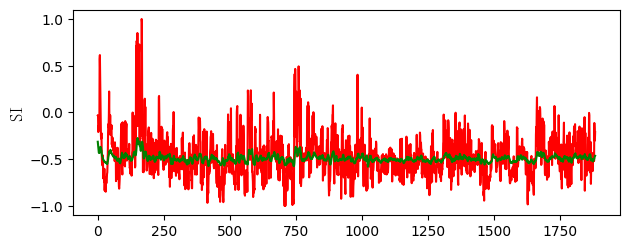

In [63]:
# 模型yuce训练
y_pred_0  = model.my_predict(X_train)
# 计算 RMSE、MRE
y_test0 = y_train

plt.subplot(2, 1, 1)
plt.plot(y_test0,'r')
plt.plot(y_pred_0,'g')
plt.ylabel(input_term, fontproperties=font)  # 使用中文标签


plt.tight_layout()

plt.show()


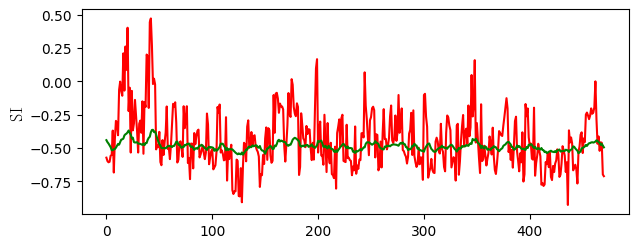

In [64]:
# 模型预测
y_pred_0  = model.my_predict(X_test)
# 计算 RMSE、MRE
y_test0 = y_test

plt.subplot(2, 1, 1)
plt.plot(y_test0,'r')
plt.plot(y_pred_0,'g')
plt.ylabel(input_term, fontproperties=font)  # 使用中文标签


plt.tight_layout()

plt.show()


In [65]:
# 要预测的时间戳范围
timestamps_to_predict = np.arange(980,2006)
timestamps_to_predict
df_sheet2 = df_sheet
df_sheet3 = pd.DataFrame()
isprint = 0
for id,item in enumerate(timestamps_to_predict):
    print(item,end='\r')
    if isprint:
        print(id,item,'000000000000000000000000000000000000000000000000000000000000000000000')
        
    item = item  # 替换成您实际的值
    leng_pre = time_steps
    # 找到比 item 小且最接近的 10 个数据
    closest_10 = df_sheet2[df_sheet2[time_term] < item].nlargest(leng_pre, time_term)
    closest_10_sorted = closest_10.sort_values(by=time_term)
    
    # 添加最新的一行数据
    new_row = {time_term: item, d_time: item - closest_10_sorted.iloc[-1][time_term], input_term: 9999}
    df_pre = pd.concat([closest_10_sorted, pd.DataFrame([new_row])], ignore_index=True)
    if isprint:
        print(df_pre)


    # 获取铁口1温度列中的数据
    temperatures = df_pre[input_term].values.tolist()

    # 获取时间差列中的数据
    time_diffs = df_pre[d_time].values.tolist()

    # 将整理后的列表转换为 NumPy 数组
    temperatures_np = np.array(temperatures)
    time_diffs_np = np.array(time_diffs)
    # 保留前两个元素
    temperatures_np = temperatures_np[:time_steps]
    time_diffs_np = time_diffs_np[-time_steps:]

    # 打印 NumPy 数组
    if isprint:
        print('铁口1温度整理成:', temperatures_np)
        print('时间差整理成:', time_diffs_np)
    temperatures_np = scalers[input_term].transform(temperatures_np.reshape(-1,1)).flatten()
    time_diffs_np = scalers[d_time].transform(time_diffs_np.reshape(-1,1)).flatten()

    X_modified = []
    X = np.column_stack((temperatures_np, time_diffs_np))
    X_modified.append(X)

    if isprint:
        print(X)

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)

    # print("Modified X_modified Shape:", X_modified.shape)
    y_pred_0  = model.my_predict(X_modified)

    # print(y_pred_0)


    temp = scalers[input_term].inverse_transform((y_pred_0)).flatten()

    if isprint:
        print(temp)
    new_row = {time_term: item, d_time: item - closest_10_sorted.iloc[-1][time_term], input_term: temp[0]}
    
    df_sheet2 = pd.concat([df_sheet2, pd.DataFrame([new_row])], ignore_index=True)
    df_sheet2 = df_sheet2.sort_values(by=time_term)
    df_sheet3 = pd.concat([df_sheet3, pd.DataFrame([new_row])], ignore_index=True)
    df_sheet3 = df_sheet3.sort_values(by=time_term)
    
    
    selected_rows = pd.concat([df_sheet2[df_sheet2[time_term] == item].iloc[-5:], df_sheet2[df_sheet2[time_term] == item].iloc[:5]])
    if isprint:
        print(selected_rows)


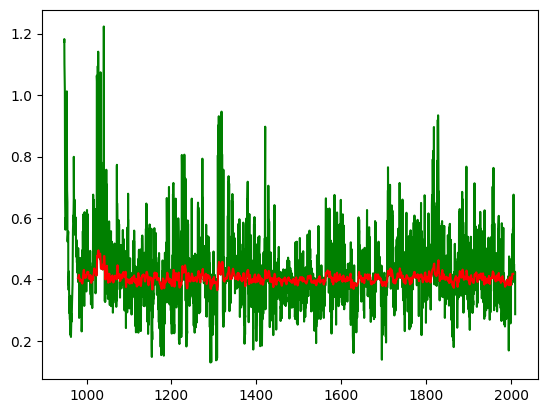

In [66]:
plt.plot(df_sheet2['时间戳'],df_sheet2['SI'],'g')
plt.plot(df_sheet3['时间戳'],df_sheet3['SI'],'r')


In [67]:
df_sheet2


,时间戳,SI,时间差
0,947.505833,1.173,0.000000
1,947.622222,1.182,0.116389
2,947.930556,1.101,0.308333
3,948.883611,1.014,0.953056
4,949.176667,0.777,0.293056
...,...,...,...
3379,2007.575278,0.391,0.543611
3380,2007.864722,0.426,0.289444
3381,2009.570278,0.424,1.705556
3382,2009.634444,0.294,0.064167


In [68]:
# 保存整理后的 df_sheet 到 Excel 文件
df_sheet2.to_excel(input_term+'_output1.xlsx', index=False)
print('DataFrame 已保存到'+input_term+' output.xlsx 文件')


DataFrame 已保存到SI output.xlsx 文件
